In [91]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy.random import randint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [92]:
# Import table with data
df_data =  pd.read_csv(f'{homedir}/ctep_wt/data/raw/protein_quantification/Ctep_growth_March2021.csv') 
#See data
df_data.head()

,Treatment,Replicate,Time point,Time_h,A669 (Chl),Bchl c (ug/ml),Calculated_cells_ml_chl,Sulfide_mM,Sulfate_mM,Date,Unnamed: 10,Unnamed: 11,Growth rate 26-0,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,a,1.0,0,0.0,NaN,0.01,388000.0,4.142700,NaN,20210324.0,NaN,NaN,NaN,NaN,NaN,NaN
1,a,1.0,0,0.0,NaN,0.01,388000.0,4.114116,NaN,20210324.0,NaN,NaN,NaN,NaN,NaN,NaN
2,a,1.0,0,0.0,NaN,0.01,388000.0,3.771108,NaN,20210324.0,NaN,NaN,NaN,NaN,NaN,NaN
3,a,2.0,0,0.0,NaN,0.01,388000.0,4.142700,NaN,20210324.0,NaN,NaN,NaN,NaN,NaN,NaN
4,a,2.0,0,0.0,NaN,0.01,388000.0,4.114116,NaN,20210324.0,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# Calculate the mean and standard deviation                           
df_growth = df_data.groupby(['Treatment','Replicate','Time_h']).agg(
                    {'Calculated_cells_ml_chl':['mean'],
                     'Sulfide_mM':['mean','std'],
                     'Sulfate_mM':['mean','std']})
#Change non existing values to 0
#df_group = df_group.fillna(0)
#Rename columns after agg
df_growth.columns = ["_".join(x) for x in df_growth.columns.ravel()]
#Drop first level of table after agg
df_growth = df_growth.reset_index()
df_growth.tail()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  if __name__ == '__main__':


,Treatment,Replicate,Time_h,Calculated_cells_ml_chl_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,Sulfate_mM_std
112,d,3.0,163.5,39100000.0,0.0,NaN,1.101000,NaN
113,d,3.0,188.0,24000000.0,0.0,NaN,1.232000,NaN
114,d,3.0,216.0,27000000.0,0.0,NaN,1.301000,NaN
115,d,3.0,244.5,27800000.0,0.0,NaN,1.398894,NaN
116,d,3.0,397.5,36000000.0,0.0,NaN,1.522020,NaN


## Plots of cells and concentrations vs. time

### b

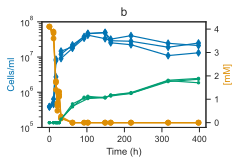

In [63]:
#Make a plot of cells and concentrations vs. time for medium
#Filter by b
df_b= df_growth[(df_growth.Treatment == 'b')]
# Group by replicate
df_treatments = df_b.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=10)
# Define markers
markers = ['d', 'o','.','s','x','d', 'o','.','s','x']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.errorbar(data.Time_h, data.Calculated_cells_ml_chl_mean,color=colors[0], marker=markers[0], label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[1], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, yerr=data.Sulfate_mM_std, color=colors[2], marker=markers[2], label = group)

    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color=colors[0])
    ax2.set_ylabel('[mM]', color=colors[1])
    ax.set_title('b', size=12)
    ax.set_yscale('log')
    ax.set_ylim([1e5, 1e8])

#Show legend
#plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/ctep_wt/figures/light_b.pdf', bbox_inches='tight')

In [80]:
#Get ratios of cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_b['ratio_cells'] = df_b['Calculated_cells_ml_chl_mean'].div(df_b.Calculated_cells_ml_chl_mean.shift(1)).fillna(0) 
#Get differences between timepoints for each treatment and Replicate
df_b['diff_time_h'] = df_b.Time_h.diff().fillna(0)
#Get differences between cells/ml between timepoints for each treatment and Replicate
df_b['diff_cells'] = df_b.Calculated_cells_ml_chl_mean.diff().fillna(0)
#Get differences between sulfide concentrations between timepoints for each ID and Replicate
df_b['diff_sulfide_mM'] = df_b.Sulfide_mM_mean.diff().fillna(0)
#Calculate growth rates in day^-1
df_b['growth_rate'] = np.log(df_b['ratio_cells'])*24/df_b['diff_time_h']
#Get maximum growth rates per ID and Replicate
df_b['max_growth_rate']= df_b['growth_rate'].max()
#Determine csSOR
df_b['csSOR'] = -(df_b['max_growth_rate']*df_b['diff_sulfide_mM']*10**9)/df_b['diff_cells']
#See dataframe
df_b.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Treatment,Replicate,Time_h,Calculated_cells_ml_chl_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,Sulfate_mM_std,ratio_cells,diff_time_h,diff_cells,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
36,b,1.0,0.00,388000.0,4.106176,0.091926,0.0,0.0,0.000000,0.00,0.0,0.000000,-inf,10.190806,NaN
37,b,1.0,11.00,453000.0,3.601868,0.131378,0.0,0.0,1.167526,11.00,65000.0,-0.504308,0.337935,10.190806,7.906617e+04
38,b,1.0,17.50,2730000.0,1.777251,0.105094,0.0,0.0,6.026490,6.50,2277000.0,-1.824618,6.631993,10.190806,8.166151e+03
39,b,1.0,21.25,NaN,0.828195,0.050723,0.0,0.0,0.000000,3.75,0.0,-0.949056,-inf,10.190806,inf
40,b,1.0,26.00,NaN,1.322771,0.131085,0.0,0.0,0.000000,4.75,0.0,0.494576,-inf,10.190806,-inf


In [78]:
#Determine growth rates
#Create a new dataframe to get growth rates from the timepoints where growth was max
df_growth_rate = df_b[(df_b.Time_h == 17.5) & (df_b.Replicate != 1)]
#Round the values of the dataframe to two decimal places
df_growth_rate = df_growth_rate.round(2)   
#See dataframe
df_growth_rate

,Treatment,Replicate,Time_h,Calculated_cells_ml_chl_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,Sulfate_mM_std,ratio_cells,diff_time_h,diff_cells,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
52,b,2.0,17.5,8640000.0,1.72,0.08,0.0,0.0,13.52,6.5,8001000.0,-2.17,9.62,10.19,2768.43
66,b,3.0,17.5,7900000.0,1.41,0.19,0.0,0.0,15.80,6.5,7400000.0,-2.42,10.19,10.19,3336.65


In [79]:
# Calculate the mean and standard deviation  
df_stats = df_growth_rate.agg(
                    {'growth_rate':['mean','std'],
                     'csSOR':['mean','std']})
df_stats


,growth_rate,csSOR
mean,9.905000,3052.540000
std,0.403051,401.792215


## d

In [94]:
#Make a plot of cells and concentrations vs. time for low nutrients
#Filter by d
df_d= df_growth[(df_growth.Treatment == 'd')]

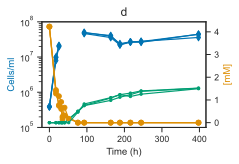

In [95]:

# Group by replicate
df_treatments = df_d.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=10)
# Define markers
markers = ['d', 'o','.','s','x','d', 'o','.','s','x']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.errorbar(data.Time_h, data.Calculated_cells_ml_chl_mean,color=colors[0], marker=markers[0], label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[1], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, yerr=data.Sulfate_mM_std, color=colors[2], marker=markers[2], label = group)

    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color=colors[0])
    ax2.set_ylabel('[mM]', color=colors[1])
    ax.set_title('d', size=12)
    ax.set_yscale('log')
    ax.set_ylim([1e5, 1e8])

#Show legend
#plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/ctep_wt/figures/light_d.pdf', bbox_inches='tight')

In [96]:
df_d = df_d[(df_d.Time_h == 0) | (df_d.Time_h == 17.5)]

#Get ratios of cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_d['ratio_cells'] = df_d['Calculated_cells_ml_chl_mean'].div(df_d.Calculated_cells_ml_chl_mean.shift(1)).fillna(0) 
#Get differences between timepoints for each treatment and Replicate
df_d['diff_time_h'] = df_d.Time_h.diff().fillna(0)
#Get differences between cells/ml between timepoints for each treatment and Replicate
df_d['diff_cells'] = df_d.Calculated_cells_ml_chl_mean.diff().fillna(0)
#Get differences between sulfide concentrations between timepoints for each ID and Replicate
df_d['diff_sulfide_mM'] = df_d.Sulfide_mM_mean.diff().fillna(0)
#Calculate growth rates in day^-1
df_d['growth_rate'] = np.log(df_d['ratio_cells'])*24/df_d['diff_time_h']
#Get maximum growth rates per ID and Replicate
df_d['max_growth_rate']= df_d['growth_rate'].max()
#Determine csSOR
df_d['csSOR'] = -(df_d['max_growth_rate']*df_d['diff_sulfide_mM']*10**9)/df_d['diff_cells']
#See dataframe
df_d

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Treatment,Replicate,Time_h,Calculated_cells_ml_chl_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,Sulfate_mM_std,ratio_cells,diff_time_h,diff_cells,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
77,d,1.0,0.0,388000.0,4.228452,0.107902,0.0,0.0,0.000000,0.0,0.0,0.000000,-inf,4.456231,NaN
78,d,1.0,17.5,7990000.0,1.371928,NaN,0.0,NaN,20.592784,17.5,7602000.0,-2.856524,4.148490,4.456231,1674.471069
90,d,2.0,0.0,388000.0,4.228452,0.107902,0.0,0.0,0.048561,-17.5,-7602000.0,2.856524,4.148490,4.456231,1674.471069
91,d,2.0,17.5,9670000.0,1.437231,NaN,0.0,NaN,24.922680,17.5,9282000.0,-2.791221,4.410210,4.456231,1340.047883
103,d,3.0,0.0,388000.0,4.228452,0.107902,0.0,0.0,0.040124,-17.5,-9282000.0,2.791221,4.410210,4.456231,1340.047883
104,d,3.0,17.5,10000000.0,1.277239,NaN,0.0,NaN,25.773196,17.5,9612000.0,-2.951213,4.456231,4.456231,1368.215330


In [97]:
#Determine growth rates
#Create a new dataframe to get growth rates from the timepoints where growth was max
df_growth_rate = df_d[(df_d.Time_h == 17.5)]
#Round the values of the dataframe to two decimal places
df_growth_rate = df_growth_rate.round(2)   
#See dataframe
df_growth_rate

,Treatment,Replicate,Time_h,Calculated_cells_ml_chl_mean,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,Sulfate_mM_std,ratio_cells,diff_time_h,diff_cells,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
78,d,1.0,17.5,7990000.0,1.37,NaN,0.0,NaN,20.59,17.5,7602000.0,-2.86,4.15,4.46,1674.47
91,d,2.0,17.5,9670000.0,1.44,NaN,0.0,NaN,24.92,17.5,9282000.0,-2.79,4.41,4.46,1340.05
104,d,3.0,17.5,10000000.0,1.28,NaN,0.0,NaN,25.77,17.5,9612000.0,-2.95,4.46,4.46,1368.22


In [98]:
# Calculate the mean and standard deviation  
df_stats = df_growth_rate.agg(
                    {'growth_rate':['mean','std'],
                     'csSOR':['mean','std']})
df_stats


,growth_rate,csSOR
mean,4.340000,1460.913333
std,0.166433,185.481063
